In [15]:
import numpy as np
import os   # 운영체제와 상호작용하기 위한 모듈

# GPU 선택 -> '1': 두 번째
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
# GPU 메모리의 동적 할당 허용
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    '가렵다',
    '기절',
    '부러지다',
    '어제',
    '어지러움',
    '열나다',
    '오늘',
    '진통제',
    '창백하다',
    '토하다'
]

data = np.concatenate([
    np.load('C:/Users/mshof/Desktop/seq_data/0505/seq_1714838622.npy')
], axis=0)

data.shape
# (데이터의 개수, 프레임 사이즈, 한 프레임당 데이터 개수)

(20330, 60, 253)

In [3]:
# 인덱스 확인
data[3000, 0, -1]

1.0

In [4]:
# 시퀀스의 마지막 열 제외한 모든 열 가져와 할당
# 첫 번째 행의 마지막 열은 라벨 값
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(data.shape)
print(labels.shape)
print(np.unique(labels))    # 레이블 값 출력

(20330, 60, 253)
(20330,)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [5]:
from tensorflow import keras
from keras.utils import to_categorical

# 원-핫 인코딩으로 변환
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(20330, 10)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)  # 입력 데이터
y_data = y_data.astype(np.float32)  # 레이블

# train data : validation data : test data = 6 : 2 : 2
x_train_val, x_test, y_train_val, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=2024)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.25, random_state=2024)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(12198, 60, 252) (12198, 10)
(4066, 60, 252) (4066, 10)
(4066, 60, 252) (4066, 10)


In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(128,  activation='relu', input_shape=x_train.shape[1:3]),   # input -> (None, 60, 252)
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax'),
])

# compile(최적화 알고리즘, 레이블 클래스 2개 이상일 때 사용하는 손실 함수, 모델평가지표)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               195072    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 203978 (796.79 KB)
Trainable params: 203978 (796.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    callbacks=[
        # save_best_only -> 모델 정확도가 이전보다 향상된 경우에만 모델 저장
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        # 정확도 개선이 없을시 학습률(factor) 0.5배로 감소, n 에포크 동안 개선 없을 경우 학습률 감소
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=20, verbose=1, mode='auto')
    ]
)

Epoch 1/30
381/382 [============================>.] - ETA: 0s - loss: 1.6296 - acc: 0.3867
Epoch 1: val_acc improved from -inf to 0.53197, saving model to models\model.h5
382/382 [==============================] - 19s 43ms/step - loss: 1.6298 - acc: 0.3866 - val_loss: 1.2410 - val_acc: 0.5320 - lr: 0.0010
Epoch 2/30
382/382 [==============================] - ETA: 0s - loss: 5.9740 - acc: 0.4673
Epoch 2: val_acc did not improve from 0.53197
382/382 [==============================] - 18s 46ms/step - loss: 5.9740 - acc: 0.4673 - val_loss: 2.5950 - val_acc: 0.2009 - lr: 0.0010
Epoch 3/30
381/382 [============================>.] - ETA: 0s - loss: 1.4978 - acc: 0.4244
Epoch 3: val_acc improved from 0.53197 to 0.55337, saving model to models\model.h5
382/382 [==============================] - 20s 54ms/step - loss: 1.4978 - acc: 0.4243 - val_loss: 1.1526 - val_acc: 0.5534 - lr: 0.0010
Epoch 4/30
381/382 [============================>.] - ETA: 0s - loss: 1.0312 - acc: 0.6105
Epoch 4: val_acc im

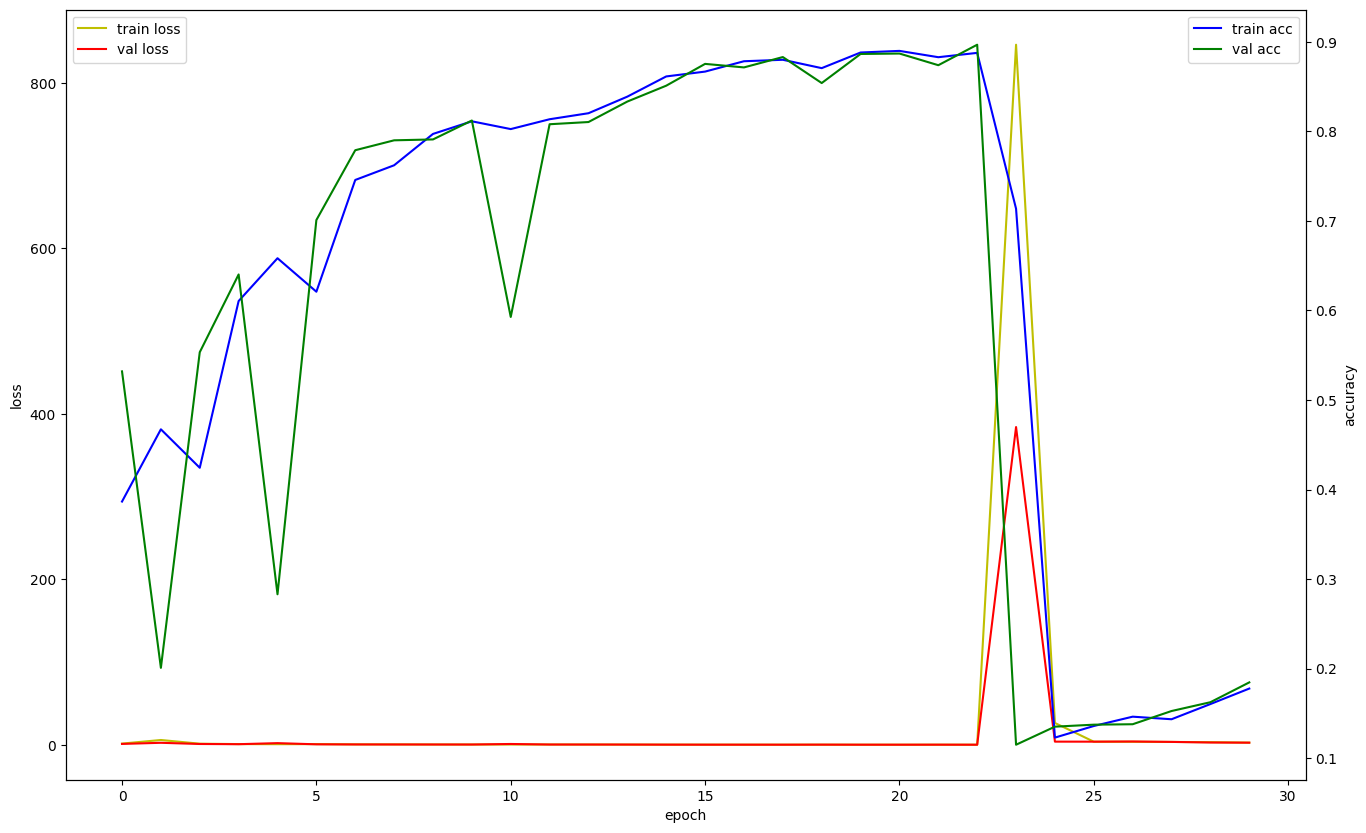

In [12]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [14]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model_pad.h5')
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"테스트 손실: {test_loss:.3f}")
print(f"테스트 정확도: {test_acc:.3f}")

y_pred = model.predict(x_val)

# 다중 레이블 혼동 행렬로 모델 평가
# [[True Negative, False Positive],
# [False Negative, True Positive]]
multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

128/128 [==============================] - 2s 11ms/step - loss: 0.2229 - acc: 0.9147
테스트 손실: 0.223
테스트 정확도: 0.915
128/128 [==============================] - 2s 10ms/step


array([[[3664,    0],
        [  40,  362]],

       [[3653,    1],
        [  15,  397]],

       [[3625,    8],
        [  86,  347]],

       [[3680,    3],
        [  45,  338]],

       [[3661,    3],
        [  35,  367]],

       [[3660,    0],
        [  85,  321]],

       [[3319,  347],
        [   3,  397]],

       [[3681,    3],
        [   0,  382]],

       [[3635,    0],
        [   4,  427]],

       [[3651,    0],
        [  52,  363]]], dtype=int64)

In [ ]:
model.summary()